# Data Exploration: Getting to know bike rentals data

The main goal of this notebook is to familiarize with the data, see the relations between features, check what is the change over time.

Due to the fact that size of collected data is over 20M records, the detailed analysis will focus mainly on records from Washington D.S. from years 2015-2018. Two main reasons behind it:
- limiting number of records will speed up calculations
- focusing on recent data will result in detecting patterns that are most up-to-date

Main metrics used in analysis:
- **number of bike rentals**: average number of rentals in day / hour
- **duration**: average rental duration
- **distance**: average distance
- **speed**: average speed

The following analysis will focus on answering how different factors influence above metrics. Main dimensions used in analysis:
- member type
- season
- month
- weekday
- weather

In [ ]:
import os
os.chdir('..')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from pandas.plotting import register_matplotlib_converters

import functions as f

pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('ggplot')
init_notebook_mode(connected=True)
sns.set()
register_matplotlib_converters()

In [15]:
df = pd.read_parquet('data/data_bikerental.parquet')
df_hourly = pd.read_parquet('data/data_hourly.parquet')
df_hourly_byMember = pd.read_parquet('data/data_hourly_byMember.parquet')
df_daily_byMember = pd.read_parquet('data/data_daily_byMember.parquet')

## Monthly number of bike rentals

The following graph shows changes in number of monthly bike rentals with division by member type. It's easy to see that the trend is positive and seasonality also occurs (however the yearly pattern is not very regular - it can be due to moving holidays or differences in weather).

Users with Member plan generate majority of rides - around 3 times more than Casual members. While number of rides generated by Members is still growing, number of rides from Casual users declined in 2018 (compared to 2017).

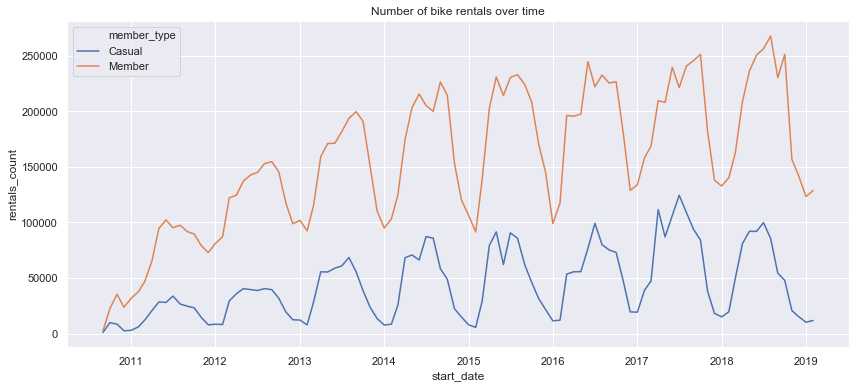

In [3]:
# Seaborn version of the chart - in case plotly graph doesn't show
df_monthly = f.round_byTime(df_daily_byMember, 'MS',
                            other_cols=['member_type'],
                            agg={'rentals_count': 'sum', 'avg_duration': 'mean'})

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot('start_date', 'rentals_count', hue='member_type', data=df_monthly)
ax.set_title('Number of bike rentals over time')
plt.show()

In [4]:
# Interactive plotly version of the plot
df_monthly_pivot = pd.pivot_table(df_monthly, values=['rentals_count', 'avg_duration'], index=['start_date'], columns=['member_type']).reset_index()
df_monthly_pivot.columns = ['_'.join(col) for col in df_monthly_pivot.columns]

trace0 = go.Scatter(
    x = df_monthly_pivot['start_date_'],
    y = df_monthly_pivot['rentals_count_Member'],
    mode = 'lines',
    name = 'Member',
    line = dict(
        color = ('rgb(170,186,215)'),
        width = 3)
)

trace1 = go.Scatter(
    x = df_monthly_pivot['start_date_'],
    y = df_monthly_pivot['rentals_count_Casual'],
    mode = 'lines',
    name = 'Casual',
    line = dict(
        color = ('rgb(228,193,178)'),
        width = 3)
)

layout = go.Layout(
    title='Number of bike rentals over time',
    yaxis=dict(
        title='number of bike rentals'
    ),
    xaxis=dict(
        title='date of bike rental'
    ),
    legend=dict(x=-.1, y=1.2)
)

plot_data = [trace0, trace1]
fig = dict(data=plot_data, layout=layout)
iplot(fig)

In [16]:
df_hourly = f.limit_byDates(df_hourly)
df_hourly_byMember = f.limit_byDates(df_hourly_byMember)
df_daily_byMember = f.limit_byDates(df_daily_byMember)

## Differences in behaviour between Member and Casual users

In the first chart there is comparison of number of daily rentals generated by two types of users. It confirms the information from the previous visualization - Member users rent more bikes than Casual users.

But the scale is not the only difference between Member and Casual users. The second distribution shows differences in ride duration (of rides of 'normal' length) - majority of rides from Member users is short (probably quick rides from point A to B), while distribution of Casual rides is more stretched and those users are responsible for the long tail of the distribution. There is also clear difference in speed of Member and Casual users - Member users tend to have higher speed than the Casual ones. There could be two possible reasons:

* Member users ride faster
* Casual users borrow bikes for the trips and they do more stops (that's why duration is longer and as a result, speed is lower)

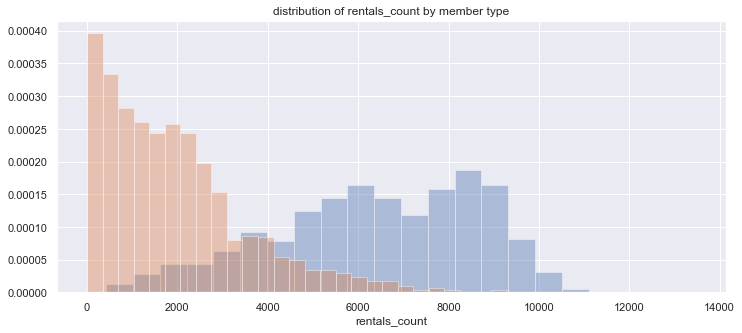

In [6]:
f.dist_byMember(df_daily_byMember, 'rentals_count')

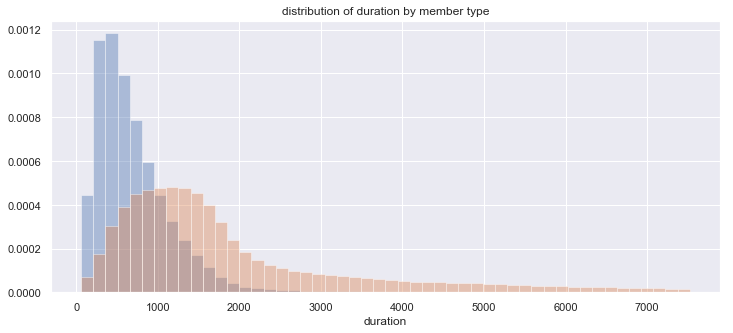

In [7]:
f.dist_byMember(df[df['ride_length']=='normal'], 'duration')

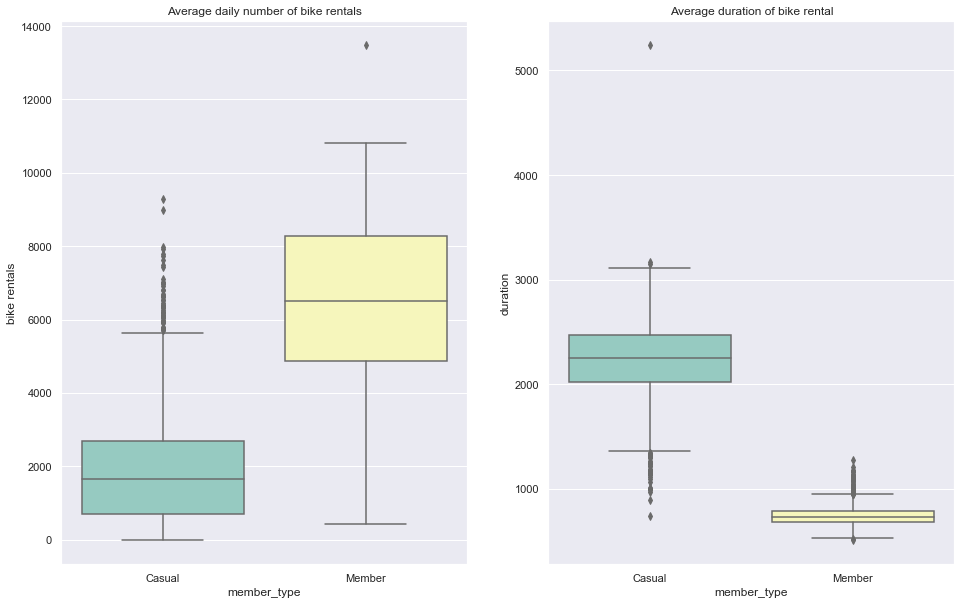

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
palette = sns.color_palette("Set3", 10)

sns.boxplot(x='member_type', y='rentals_count', data=df_daily_byMember, ax=ax1, palette=palette)
ax1.set_title('Average daily number of bike rentals')
ax1.set_ylabel('bike rentals')

sns.boxplot(x='member_type', y='avg_duration', data=df_daily_byMember, ax=ax2, palette=palette)
ax2.set_title('Average duration of bike rental')
ax2.set_ylabel('duration')

plt.show()

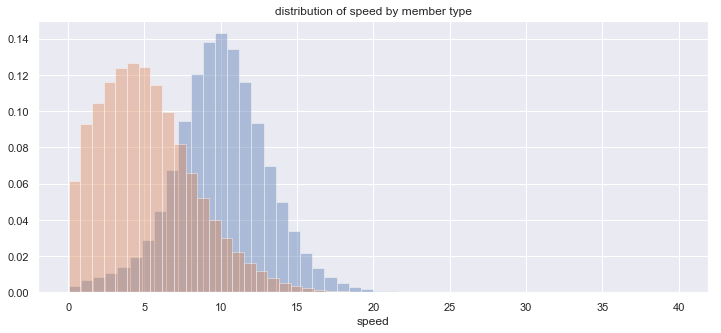

In [9]:
f.dist_byMember(df[~df['speed'].isna()], 'speed')

## Differences in behaviour in different months

It's undestandable that the highest number of bike rentals falls on the warm months, for Casual users: from April till August, for Member users from June to October.

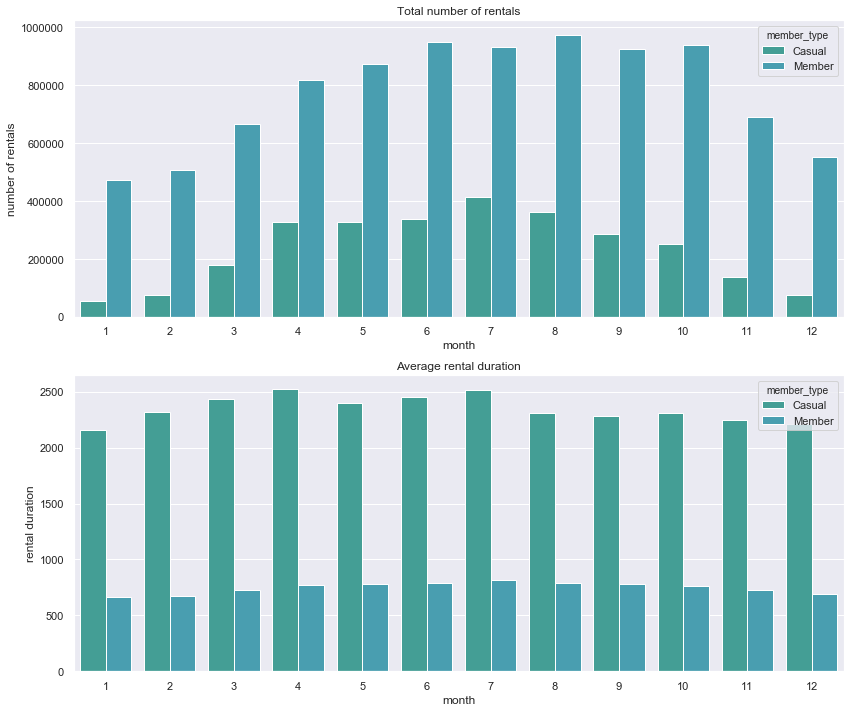

In [10]:
df_byMonth = df.groupby(['month', 'member_type']) \
                .agg({'rental_id': 'count', 'duration': 'mean'}) \
                .reset_index()
f.draw_overview_plot('month', df_byMonth, 'member_type')

## Differences in behaviour in different weekdays

By observing number of bike rentals on each weekday, we can conclude that Member users tend to ride a bike from Monday to Friday (probably to work, university, school), while Casual users are most active during weekends (bike trips).

It seems that duration of ride doesn't depend on weekday for Member users and for Casual riders it's slightly longer during the weekend.

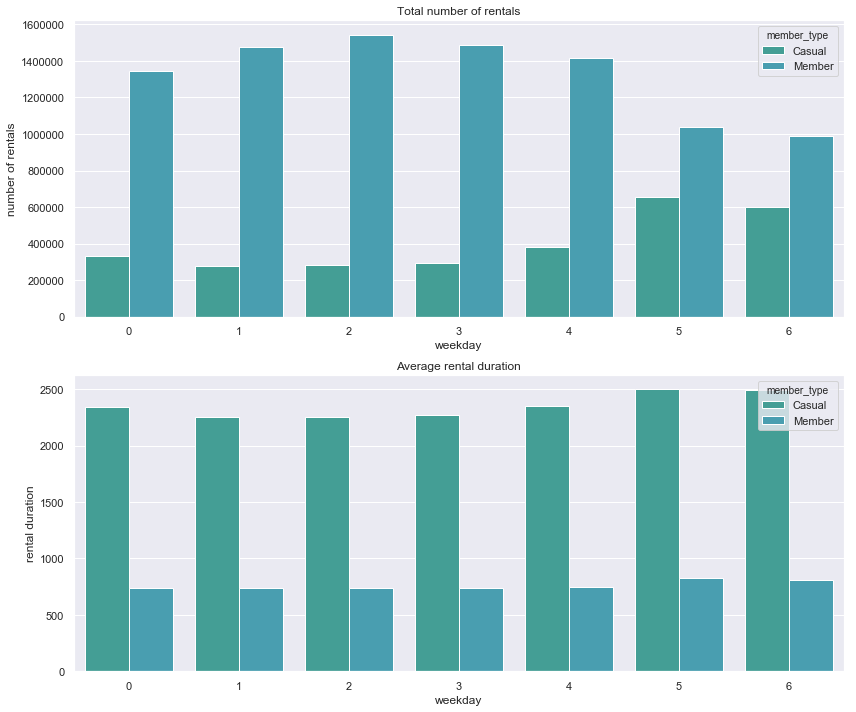

In [11]:
df_byWeekday = df.groupby(['weekday', 'member_type']) \
                .agg({'rental_id': 'count', 'duration': 'mean'}) \
                .reset_index()
f.draw_overview_plot('weekday', df_byWeekday, 'member_type')

In [12]:
df_daily_byMember['weekday'] = df_daily_byMember['start_date'].dt.weekday
df_daily_byMember['part_of_week'] = df_daily_byMember['weekday'].apply(lambda x: 'weekday' if x < 5 else 'weekend')

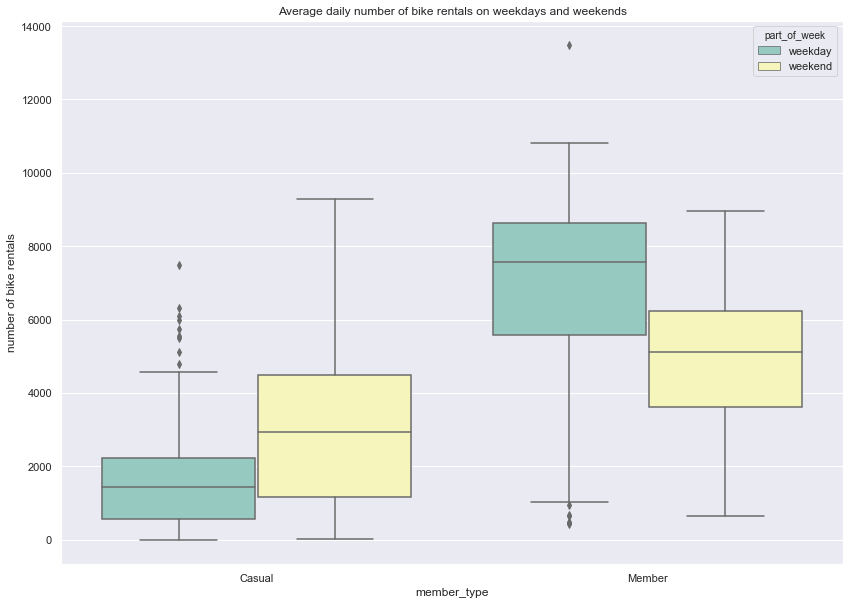

In [13]:
fig, ax = plt.subplots(figsize=(14, 10))
palette = sns.color_palette("Set3", 10)
sns.boxplot(x='member_type', y='rentals_count', hue='part_of_week', data=df_daily_byMember, palette=palette)
ax.set_title('Average daily number of bike rentals on weekdays and weekends')
ax.set_ylabel('number of bike rentals')
plt.show()

In [18]:
df_hourly_byMember['hour'] = df_hourly_byMember['start_date'].dt.hour
df_hourly['hour'] = df_hourly['start_date'].dt.hour
df_hourly['month'] = df_hourly['start_date'].dt.month
df_hourly['season'] = df_hourly['month'].apply(f.meteo_season)

df_byHour = df_hourly_byMember.groupby(['hour', 'member_type']) \
            .agg({'rentals_count': 'sum', 'avg_duration': 'mean'}) \
            .reset_index()

## Difference in behaviour in different time in a day

For Member users there are two peaks during the day when number of bike rentals is the highest: in the morning (around 7-9am) and in the afternoon (around 4-6pm). It is in line with the hypothesis that those users rent a bike to get to / back from work or school. For Casual users there's no clear peak, however between 11am - 5pm the activity is the highest.

When it comes to duration, for Member users at every hour it's on similar level. Casual users have the longest rides between 9am - 3pm and at night, between 1am and 4am.

The pattern of number of bike rentals in an hour doesn't change throughout the seasons - only the level of number of rentals is the lowest in the winter and the highest in the summer. Summer has the highest hourly average of bike rentals and it also characterized with the biggest variance of number of hourly bike rentals. At the same time, winter has the lowest average number of hourly bike rentals and also standard deviation is the lowest.

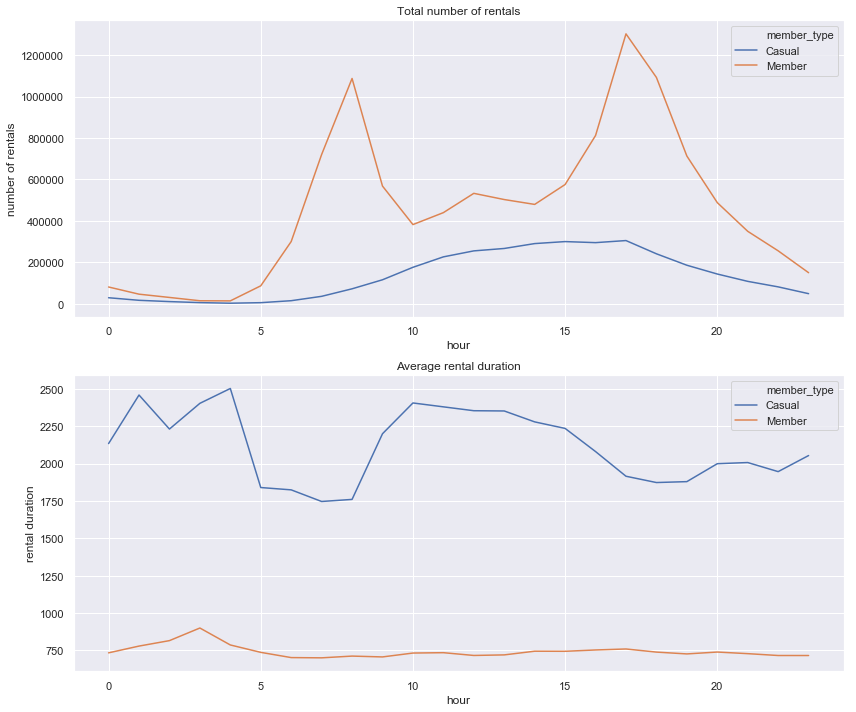

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
palette = sns.husl_palette(10, h=.5)

sns.lineplot(x='hour', y='rentals_count', hue='member_type', data=df_byHour, ax=ax1, ci=None)
ax1.set_title('Total number of rentals')
ax1.set_ylabel('number of rentals')

sns.lineplot(x='hour', y='avg_duration', hue='member_type', data=df_byHour, ax=ax2, ci=None)
ax2.set_title('Average rental duration')
ax2.set_ylabel('rental duration')

plt.tight_layout()
plt.show()

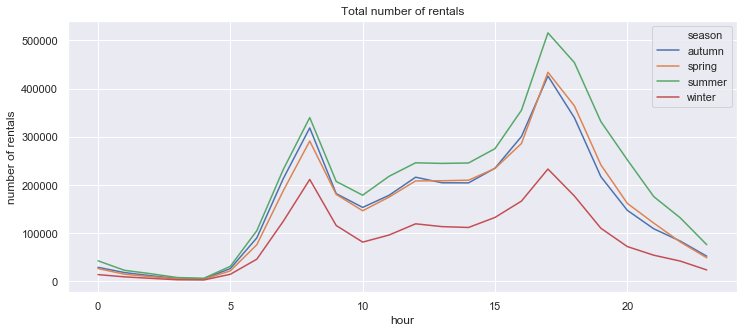

In [20]:
df_byHourSeason = df_hourly.groupby(['hour', 'season']).agg({'rentals_count': 'sum', 'avg_duration': 'mean'}).reset_index()

fig, ax = plt.subplots(figsize=(12, 5))
palette = sns.husl_palette(10, h=.5)

sns.lineplot(x='hour', y='rentals_count', hue='season', data=df_byHourSeason, ci=None)
ax.set_title('Total number of rentals')
ax.set_ylabel('number of rentals')

plt.show()

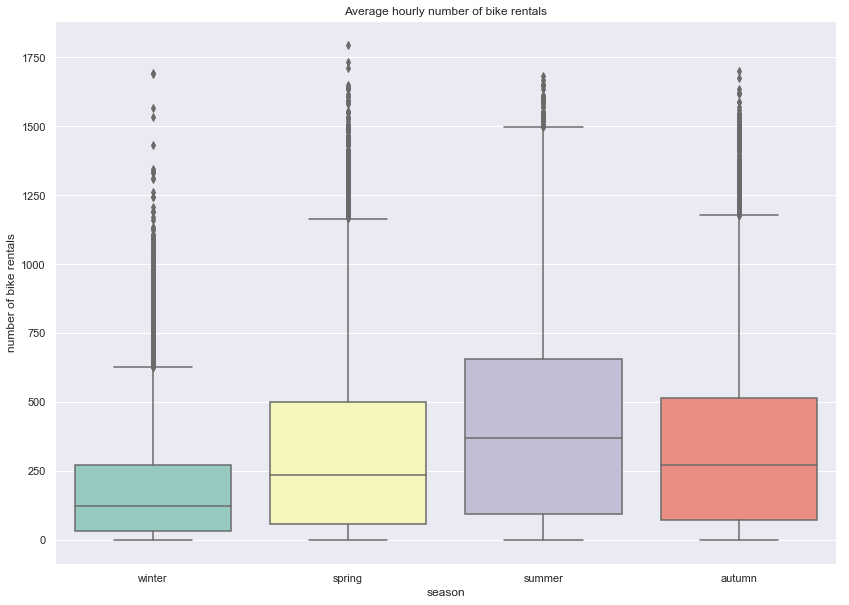

In [21]:
fig, ax = plt.subplots(figsize=(14, 10))
palette = sns.color_palette("Set3", 10)
sns.boxplot(x='season', y='rentals_count', hue=None, data=df_hourly, palette=palette)
ax.set_title('Average hourly number of bike rentals')
ax.set_ylabel('number of bike rentals')
plt.show()

## Relations between features

Correlation matrix shows that number of hourly rentals has strong positive correlation with temperature. Also average rental duration depends on it. Between rentals' count and average duration there is correlation at the level of 0.49.

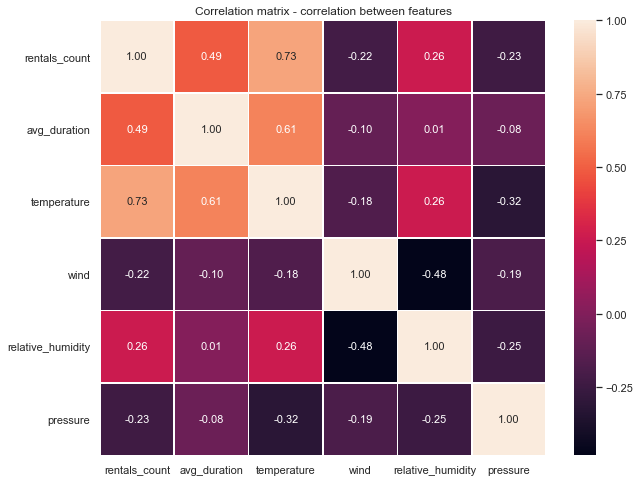

In [22]:
df_byDay = df_hourly.groupby(['date', 'season']) \
                    .agg({'rentals_count': 'sum',
                          'avg_duration': 'mean',
                          'temperature': 'mean',
                          'wind': 'mean',
                          'relative_humidity': 'mean',
                          'pressure': 'mean'}) \
                    .reset_index()

corr= df_byDay.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, annot_kws={'size': 11}, linewidths=.5, fmt='.2f', ax=ax)
ax.set_title('Correlation matrix - correlation between features')
plt.show()

C:\Users\Klaudia\Anaconda3\envs\bikerental\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\Klaudia\Anaconda3\envs\bikerental\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning:

invalid value encountered in less_equal



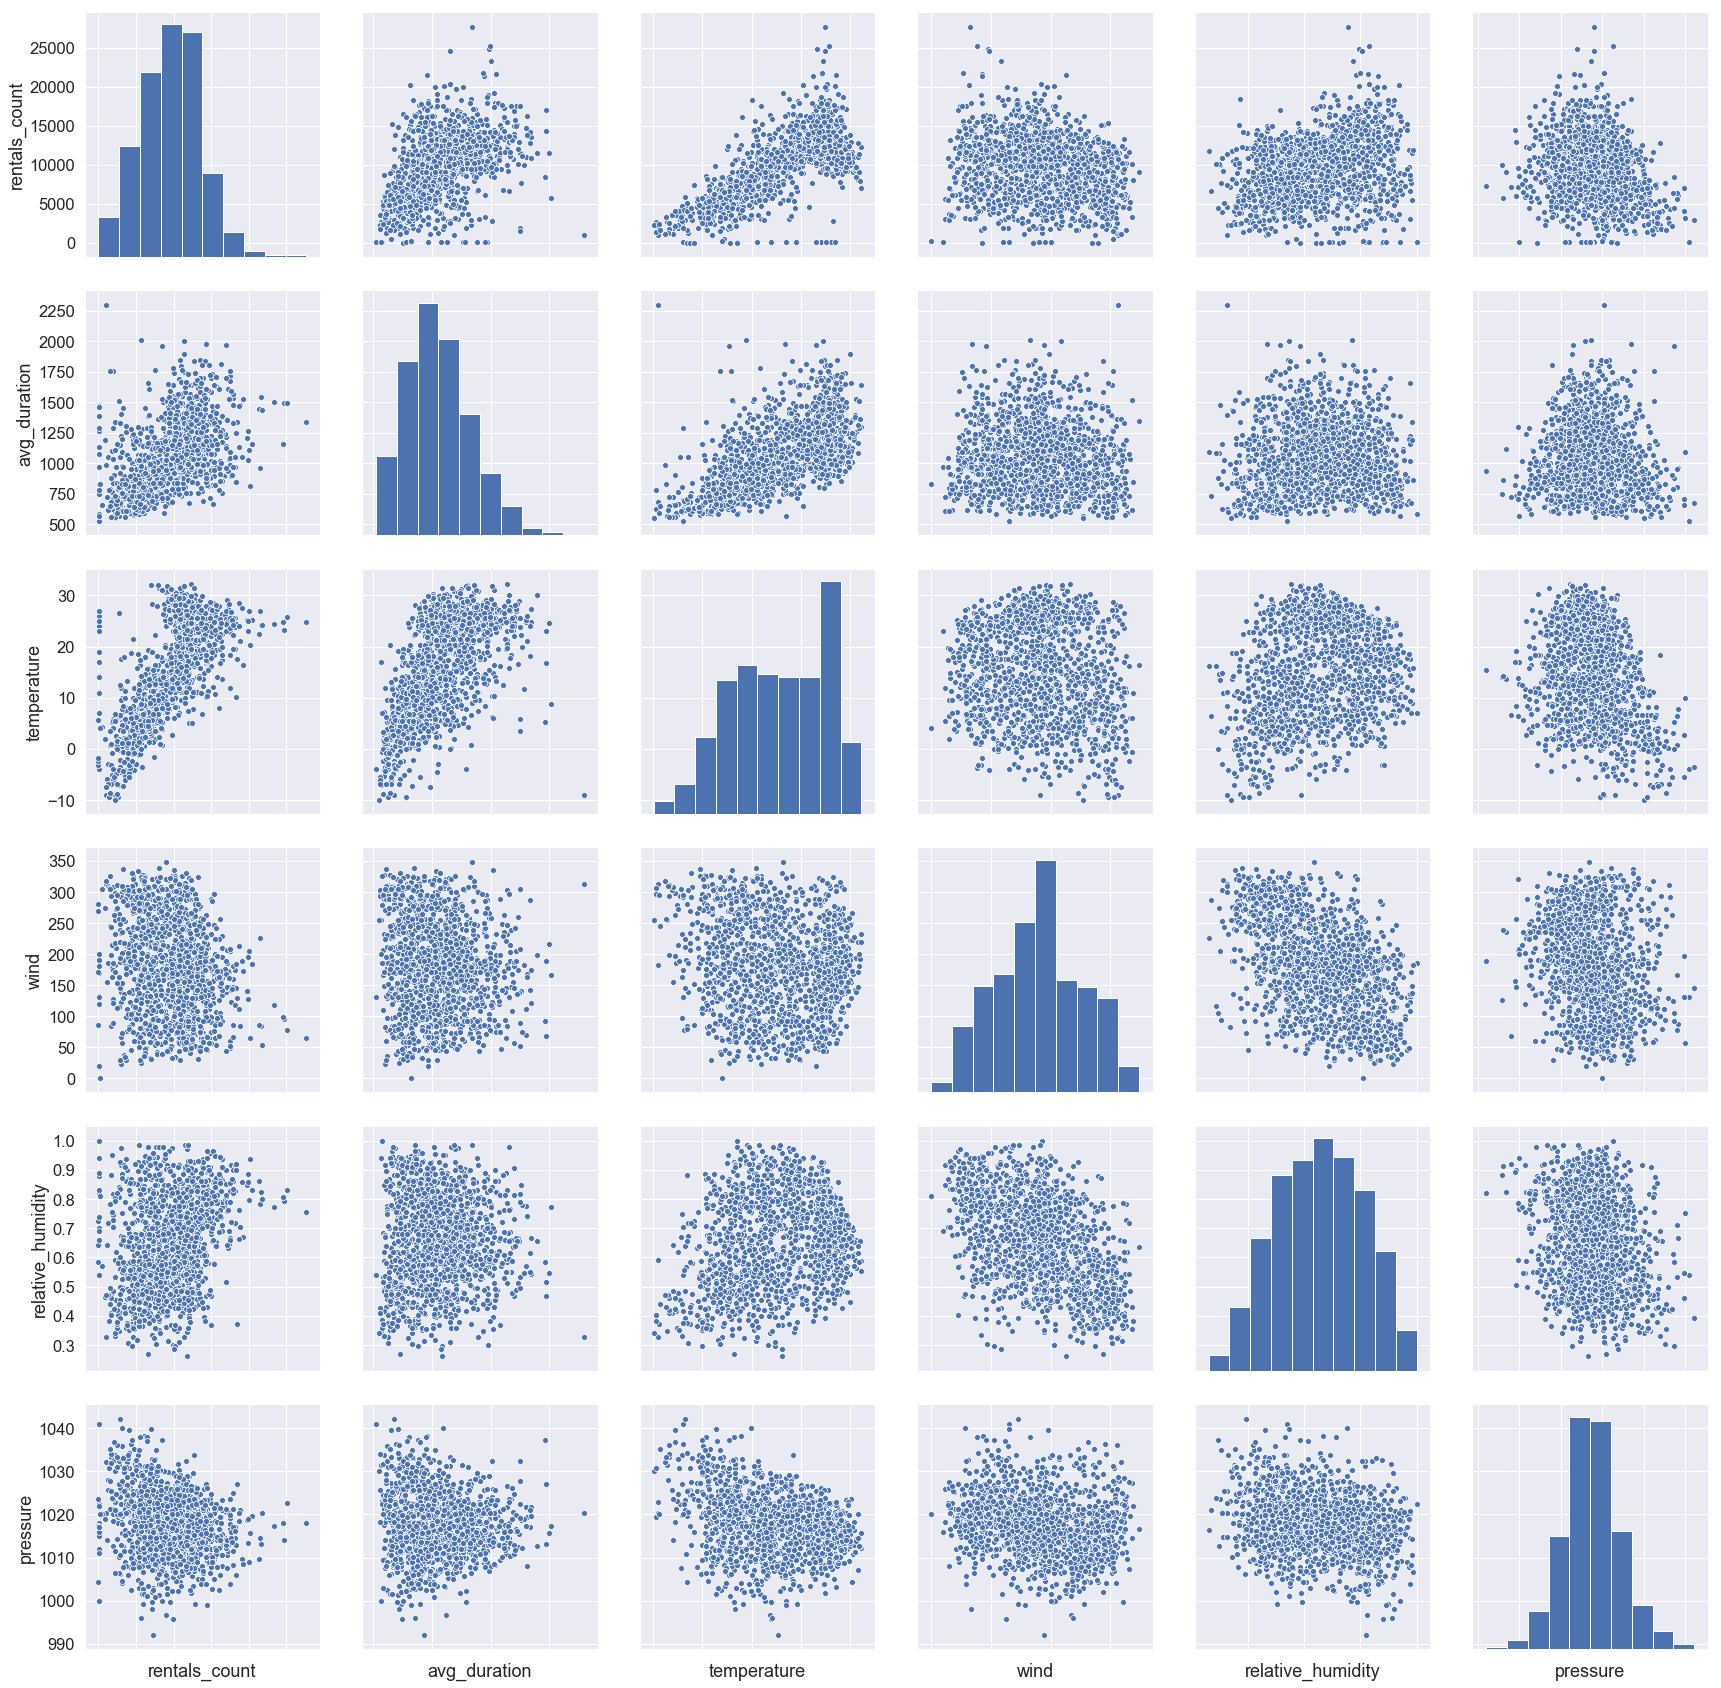

In [23]:
with sns.plotting_context("notebook",font_scale=1.5):
    g = sns.pairplot(data=df_byDay[['rentals_count', 'avg_duration', 'temperature', 'wind', 'relative_humidity', 'pressure']], height=4)
g.set(xticklabels=[]);

## Weather influence on bike rentals

Box plots below show that rain and snow have influence on number of bike rentals in an hour - users are less eager to rent a bike when it rains or snows. At the same time, there is no such difference when it comes to thunder - possible explanation is that thunder is usually sth unexpected and short so users don't have enough time to change their decisions about mean of transportation.

The second chart shows that users tend to rent less bikes when the sky is clear (compared to cloudy and partly cloudy). The possible explanation is that riding in full sun is more tiring and less pleasant so users try to avoid it and choose cloudy days for their bike trips.

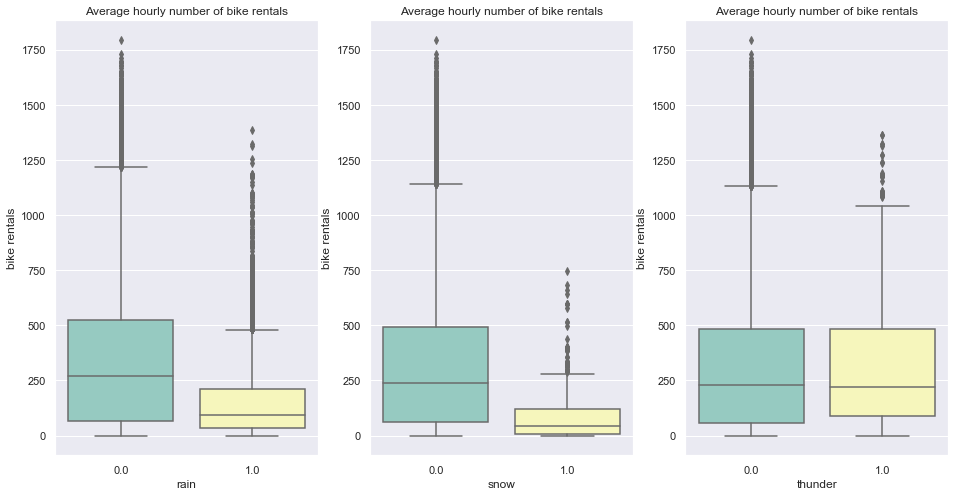

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
palette = sns.color_palette("Set3", 10)

sns.boxplot(x='rain', y='rentals_count', data=df_hourly, ax=ax1, palette=palette)
ax1.set_title('Average hourly number of bike rentals')
ax1.set_ylabel('bike rentals')

sns.boxplot(x='snow', y='rentals_count', data=df_hourly, ax=ax2, palette=palette)
ax2.set_title('Average hourly number of bike rentals')
ax2.set_ylabel('bike rentals')

sns.boxplot(x='thunder', y='rentals_count', data=df_hourly, ax=ax3, palette=palette)
ax3.set_title('Average hourly number of bike rentals')
ax3.set_ylabel('bike rentals')

plt.show()

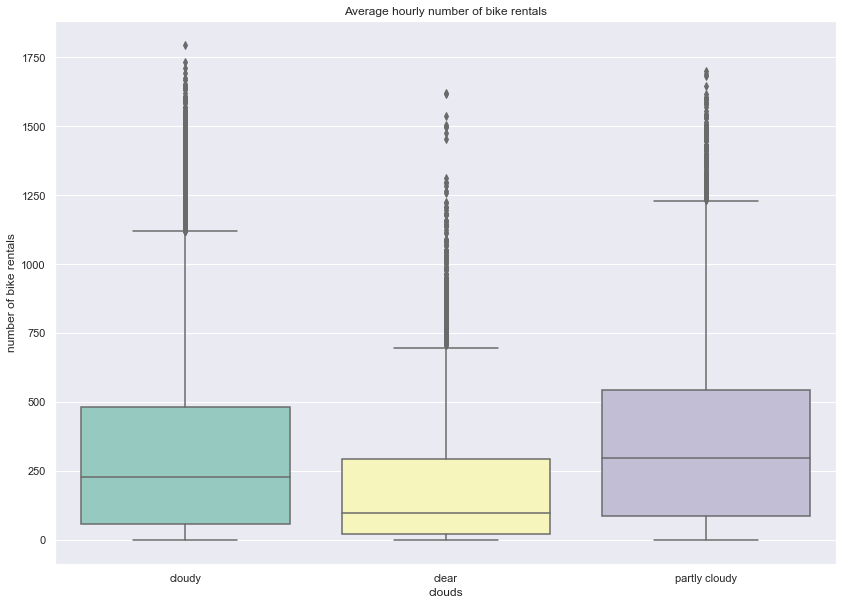

In [25]:
fig, ax = plt.subplots(figsize=(14, 10))
palette = sns.color_palette("Set3", 10)
sns.boxplot(x='clouds',
            y='rentals_count',
            hue=None,
            data=df_hourly[df_hourly['clouds'].isin(['cloudy', 'clear', 'partly cloudy'])],
            palette=palette)
ax.set_title('Average hourly number of bike rentals')
ax.set_ylabel('number of bike rentals')
plt.show()